In [114]:
%matplotlib notebook

import cvxpy as cp
import dccp
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from cvxpylayers.torch import CvxpyLayer
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from numpy import genfromtxt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

torch.set_default_dtype(torch.float64)
SEED = 0
SAFETY_COSNT = 1e-5
TRAIN_SLOPE = 3
X_LOWER_BOUND = -10
X_UPPER_BOUND = 10

In [115]:
def reset_seed():
    torch.manual_seed(SEED)
    np.random.seed(SEED)

In [116]:
def shuffle(X, Y):
    reset_seed()
    data = torch.cat((Y, X), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, 1:]
    Y = data[:, 0]
    return X, Y

def gen_sklearn_data(N, x_dim, informative_frac=1, shift_range=1, scale_range=1, noise_frac=0.01, seed=0):
    reset_seed()
    n_informative = int(informative_frac*x_dim)
    n_redundant = x_dim - n_informative
    shift_arr = shift_range*np.random.randn(x_dim)
    scale_arr = scale_range*np.random.randn(x_dim)
    X, Y = make_classification(n_samples=N, n_features=x_dim, n_informative=n_informative, n_redundant=n_redundant,
                               flip_y=noise_frac, shift=shift_arr, scale=scale_arr, random_state=seed)
    Y[Y == 0] = -1
    return torch.from_numpy(X), torch.from_numpy(Y)

def gen_custom_normal_data(N, x_dim, pos_mean, pos_std, neg_mean, neg_std, pos_noise_frac=0.01, neg_noise_frac=0.01):
    reset_seed()
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.randn((pos_samples_num, x_dim))*pos_std + pos_mean
    negX = torch.randn((neg_samples_num, x_dim))*neg_std + neg_mean
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.from_numpy(np.random.choice([1, -1], len(posX), p=[1-pos_noise_frac, pos_noise_frac])),
                                   torch.from_numpy(np.random.choice([-1, 1], len(posX), p=[1-neg_noise_frac, neg_noise_frac]))),
                                  0), 1)
    
    X, Y = shuffle(X, Y)
    return X, Y

def visualize_data2D(X, y):
    if not X.size(1) == 2:
        return
    
    Xpos = X[y == 1]
    Xneg = X[y == -1]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='red')
    plt.show()
    
def visualize_seperator2D(model, X, y):
    if not X.size(1) == 2:
        return

    W = model.fc.weight[0]
    b = model.fc.bias
    
    Xpos = X[y == 1]
    Xneg = X[y == -1]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='red')

    range_arr = torch.arange(-5, 5)
    xx = torch.meshgrid(range_arr)[0]
    z = (-W[0] * xx - b) * 1. /W[1]
    ax.plot(xx.detach().numpy(), z.detach().numpy(), alpha=0.2, color='green')

    plt.show()

In [117]:
def score(x, w, b):
    return x@w + b

def f(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) + 1)]), 2)

def g(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) - 1)]), 2)

def c(x, r):
    return cp.norm(x-r)

def f_derivative(x, w, b, slope):
    return 0.5*cp.multiply(slope*((slope*score(x, w, b) + 1)/cp.sqrt((slope*score(x, w, b) + 1)**2 + 1)), w)

In [118]:
class CCP:
    def __init__(self, x_dim):
        self.f_derivative = f_derivative
        self.g = g
        self.c = c
        
        self.x = cp.Variable(x_dim)
        self.xt = cp.Parameter(x_dim)
        self.r = cp.Parameter(x_dim) # original x
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1)
        self.slope = cp.Parameter(1)

        target = (self.x@self.f_derivative(self.xt, self.w, self.b, self.slope)-self.g(self.x, self.w, self.b, self.slope))-self.c(self.x, self.r)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        prob = self.prob
        
        result = prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.001 and cnt < 100:
            cnt += 1
            self.xt.value = self.x.value
            result = prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, r, w, b, slope):
        """
        tensor to tensor
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        slope = np.full(1, slope)
        X = X.detach().numpy()
        
        self.w.value = w
        self.b.value = b
        self.slope.value = slope
        
        return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])

In [119]:
class DELTA():
    
    def __init__(self, x_dim):
        self.g = g
        self.c = c
        
        self.x = cp.Variable(x_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))

        target = (self.x@self.f_der-self.g(self.x, self.w, self.b, TRAIN_SLOPE))-self.c(self.x, self.r)

        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.f_der],
                                variables=[self.x])
        
    def optimize_X(self, X, r, w, b, F_DER):
        return self.layer(X, w, b, F_DER)[0]

In [120]:
class SSVM(nn.Module):
    def __init__(self, x_dim, model_type="SVM"):
        super().__init__()
        reset_seed()
        self.x_dim = x_dim
        assert model_type in ["SVM", "naive_SSVM", "SSVM"]
        self.model_type = model_type
        self.fc = nn.Linear(x_dim, 1, bias=True)
        self.relu = nn.ReLU()
#         self.ccp = CCP(x_dim)
#         self.delta = DELTA(x_dim)
        self.train_slope = TRAIN_SLOPE
        
    def reset(self):
        reset_seed()
        self.fc = nn.Linear(self.x_dim, 1, bias=True)

    def forward(self, X):
        return torch.flatten(self.fc(X))
    
    def optimize_X(self, X, r):
        W = self.fc.weight[0]
        b = self.fc.bias
        
        norm = torch.norm(W, p=2)
        distances = torch.sign(r)*self.forward(X)/norm
        X_moved = torch.stack([x - (1+SAFETY_COSNT)*torch.sign(_r)*d*W/norm for x, _r, d in zip(X, r, distances)])
        cond1 = -2*torch.abs(r) <= distances
        cond2 = distances < 0
        cond = cond1*cond2
        cond = cond.repeat((X.size(1), 1)).T
        X_opt = torch.where(cond, X_moved, X)
#         X_opt = torch.stack([x - (1+SAFETY_COSNT)*torch.sign(_r)*d*W/norm if (-2*torch.abs(_r) <= d < 0) else x for (x, _r, d) in zip(X, r, distances)])
        return X_opt

    def optimize_X_scmp(self, X, r):
#         W = self.fc.weight[0]
#         b = self.fc.bias
        
#         XT = self.ccp.optimize_X(X, r, W, b, self.train_slope)
#         F_DER = self.get_f_ders(XT, self.train_slope)
#         X_opt = self.delta.optimize_X(X, r, W, b, F_DER)
        W = self.fc.weight[0]
        b = self.fc.bias
        beta = 10
        
        norm = torch.norm(W, p=2)
        distances = torch.sign(r)*self.forward(X)/norm
        X_moved = torch.stack([x - (1+SAFETY_COSNT)*torch.sign(_r)*d*W/norm for x, _r, d in zip(X, r, distances)])
        cond1 = distances + 2*torch.abs(r)
        cond2 = -distances
        cond = cond1*cond2*beta
        cond = cond.repeat((X.size(1), 1)).T
        X_opt = torch.sigmoid(cond)*X_moved + (1-torch.sigmoid(cond))*X
        return X_opt
    
    def get_f_ders(self, XT, slope):
        W = self.fc.weight[0]
        
        return torch.stack([0.5*slope*((slope*self.forward(xt) + 1)/torch.sqrt((slope*self.forward(xt) + 1)**2 + 1))*W for xt in XT])
    
    def predict(self, X):
        y_hat = self.forward(X)
        y_hat[torch.abs(y_hat) < 1e-10] = 0
        return torch.sign(y_hat)
    
    def calc_accuracy(self, y, y_pred):
        num = len(y)
        temp = torch.abs(y - y_pred)
        acc = len(temp[temp < 2])*1./num
        return acc
    
#     def compare_strategic_and_non_strategic_accuracy(self, X, y, radius=2):
#         X_opt = self.optimize_X(X, y, radius=radius)
#         non_strategic_accuracy = self.calc_accuracy(y, self.predict(X))
#         strategic_accuracy = self.calc_accuracy(y, self.predict(X_opt))
#         return non_strategic_accuracy, strategic_accuracy
    
    def evaluate(self, X_test, r_test, y_test):
        X_test_opt = self.optimize_X(X_test, r_test)
        non_strategic_accuracy = self.calc_accuracy(y_test, self.predict(X_test))
        strategic_accuracy = self.calc_accuracy(y_test, self.predict(X_test_opt))
        
        if self.model_type == "naive_SSVM":
            X_test = X_test_opt
            
        hinge_loss = self.hinge_loss(X_test, r_test, y_test).item()
        norm = self.regularization_loss().item()
        return [non_strategic_accuracy, strategic_accuracy, hinge_loss, norm]
    
    def regularization_loss(self):
        W = self.fc.weight[0]
        return (torch.norm(W, p=2)**2)
    
    def hinge_loss(self, X, r, y):
        if self.model_type == "SVM":
            return torch.mean(self.relu(1 - y*self.forward(X)))
        if self.model_type == "naive_SSVM":
            return torch.mean(self.relu(1 - y*self.forward(self.optimize_X_scmp(X, r))))
        else: #smart SSVM
            W = self.fc.weight[0]
            return torch.mean(self.relu(1  - y*self.forward(X) - 2*r*y*torch.norm(W, p=2)))
    
    def loss(self, h_loss, r_loss, lam):
        return lam*r_loss + h_loss
    
    def fit(self, X, r, y, Xval, rval, yval, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, lam=0, verbose=False):
        reset_seed()
        train_dset = TensorDataset(X, r, y)
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        opt = opt(self.parameters(), **opt_kwargs)
        train_losses, val_losses, train_errors, val_errors = [], [], [], []
        
        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for X, r, y in train_loader:
                opt.zero_grad()
                l = self.loss(self.hinge_loss(X, r, y), self.regularization_loss(), lam)
                l.backward()
                opt.step()
                train_losses[-1].append(l.item())
                with torch.no_grad():
                    if self.model_type == "SVM":
                        error = 1-self.calc_accuracy(y, self.predict(X))
                    else:
                        error = 1-self.calc_accuracy(y, self.predict(self.optimize_X(X, r)))
                    train_errors[-1].append(error)
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f | err: %3.5f" %
                          (batch, len(train_loader), np.mean(train_losses[-1]), np.mean(train_errors[-1])))
                batch += 1
                
#             with torch.no_grad():
#                 if self.model_type == "naive_SSVM":
#                     Xval = self.optimize_X(Xval, yval)
#                 yval_hat = self.forward(Xval)
#                 val_loss = self.loss(self.hinge_loss(yval, yval_hat), self.regularization_loss(), lam)
#                 val_losses.append(val_loss)
#                 val_error = 1-self.calc_accuracy(yval, self.predict(Xval))
#                 val_errors.append(val_error)
            
            t2 = time.time()
            if verbose:
                print("------------- epoch %03d / %03d | time: %03d sec | loss: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_errors[-1]))
        
#         print("Total training time: {} seconds".format(time.time()-total_time)) 
        return train_errors, val_errors, train_losses, val_losses

In [127]:
def train_CV(model_type, X_train, r_train, y_train, X_test, r_test, y_test, lambdas, n_splits, lr, batch_size, epochs):
    model = SSVM(X_train.shape[1], model_type)
    stats = []
    learning_params = {"opt": torch.optim.Adam, "opt_kwargs": {"lr": lr},
                            "batch_size": batch_size, "epochs": epochs, "verbose": False}
    
    kf = KFold(n_splits=n_splits)
    for lam in lambdas:
        for train_index, test_index in kf.split(X_train):
            
            stats_tmp = []

            _X_train, _X_test = X_train[train_index], X_train[test_index]
            _r_train, _r_test = r_train[train_index], r_train[test_index]
            _y_train, _y_test = y_train[train_index], y_train[test_index]
                        
            #train
            model.reset()
            model.fit(_X_train, _r_train, _y_train, None, None, None, **learning_params, lam=lam)

            #evaluate
            stats_tmp.append(model.evaluate(_X_test, _r_test, _y_test))
            
        stats.append(np.mean(stats_tmp, axis=0))
    
    if model_type == "SVM":
        best_acc_idx = np.argmax(np.array(stats)[:, 0])
    else:
        best_acc_idx = np.argmax(np.array(stats)[:, 1])
    best_lam = lambdas[best_acc_idx]
    
    model.reset()
    train_errors, _, _, _ = model.fit(X_train, r_train, y_train, None, None, None, **learning_params, lam=best_lam)
    
    best_stats = model.evaluate(X_test, r_test, y_test)
    best_stats[2]  = 1-np.mean(np.array(train_errors)[-1])                             # ABUSE!!!!!!!
    return model, best_stats


def mean_and_std_accuracy(N, model_type, frac, train_size, test_size, X_train, r_train, y_train, X_test, r_test, y_test, lambdas, n_splits, lr, batch_size, epochs):
    effective_train_size = int(frac*train_size)
    stats = []
    for i in range(N):
        curr_X_train, curr_r_train, curr_y_train = X_train[i*train_size:i*train_size + effective_train_size], r_train[i*train_size:i*train_size + effective_train_size], y_train[i*train_size:i*train_size + effective_train_size]
        curr_X_test, curr_r_test, curr_y_test = X_test[i*test_size:(i+1)*test_size], r_test[i*test_size:(i+1)*test_size], y_test[i*test_size:(i+1)*test_size]
        stats.append(train_CV(model_type, curr_X_train, curr_r_train, curr_y_train, curr_X_test, curr_r_test, curr_y_test, lambdas, n_splits, lr, batch_size, epochs)[1])
    return stats

# N = number of repetitions
def mean_and_std_accuracy_per_frac(N, model_type, X, r, y, train_fracs, train_size, test_size, lambdas, n_splits, lr, batch_size, epochs):
    assert model_type in ["SVM", "naive_SSVM", "SSVM"]
    
    X_train, r_train, y_train = X[:N*train_size], r[:N*train_size], y[:N*train_size]
    X_test, r_test, y_test = X[N*train_size:], r[N*train_size:], y[N*train_size:]
    
    mean_acc_ns = []
    std_acc_ns = []
    all_accuracies_ns = [] # non strategic
    mean_acc_s = []
    std_acc_s = []
    all_accuracies_s = [] # non strategic
    
    t_mean_acc = []

    for frac in tqdm(train_fracs):
        stats = mean_and_std_accuracy(N, model_type, frac, train_size, test_size, X_train, r_train, y_train, X_test, r_test, y_test, lambdas, n_splits, lr, batch_size, epochs)
        stats = np.array(stats)
        
        accuracies_ns = stats[:, 0]
        mean_acc_ns.append(np.mean(accuracies_ns))
        std_acc_ns.append(np.std(accuracies_ns))
        all_accuracies_ns.append(accuracies_ns)
        
        accuracies_s = stats[:, 1]
        mean_acc_s.append(np.mean(accuracies_s))
        std_acc_s.append(np.std(accuracies_s))
        all_accuracies_s.append(accuracies_s)
        
        t_accuracies = stats[:, 2] # train accuracies
        t_mean_acc.append(np.mean(t_accuracies)) 
        
        print(frac, np.mean(accuracies_ns), np.mean(accuracies_s), np.mean(t_accuracies))
    return mean_acc_ns, std_acc_ns, all_accuracies_ns, mean_acc_s, std_acc_s, all_accuracies_s, t_mean_acc

# train size is M - the maximum train size (when frac = 1)
def generalization_experiment(incentives, x_dim, N, train_fracs, train_size, test_size, scale_range, noise_frac, lambdas, n_splits, lr, batch_size, epochs, seed=0):
    effective_number_of_samples = N*(train_size + test_size)
    
    blobs_dist = 11
    blobs_std = 1.5
    pos_noise_frac = 0.0
    neg_noise_frac = 0.0

    X, y = gen_custom_normal_data(effective_number_of_samples, x_dim,
                              np.array([blobs_dist/2+10, 0]),
                              np.array([blobs_std, 0.2]),
                              np.array([-blobs_dist/2+10, 0]),
                              np.array([blobs_std, 0.2]),
                              pos_noise_frac=pos_noise_frac,
                              neg_noise_frac=neg_noise_frac)
#     X, y = gen_sklearn_data(effective_number_of_samples, x_dim, scale_range=scale_range, noise_frac=noise_frac, seed=seed)
    if incentives == "IA":
        r = y
    elif incentives == "ADV":
        r = -y
    elif incentives == "SC":
        r = y*y
    else: # random
        r = torch.rand(effective_number_of_samples)*2-1
        
    SVM_res = mean_and_std_accuracy_per_frac(N, "SVM", X, r, y, train_fracs, train_size, test_size, lambdas, n_splits, lr, batch_size, epochs)
    naive_SSVM_res = mean_and_std_accuracy_per_frac(N, "naive_SSVM", X, r, y, train_fracs, train_size, test_size, lambdas, n_splits, lr, batch_size, epochs)
    SSVM_res = mean_and_std_accuracy_per_frac(N, "SSVM", X, r, y, train_fracs, train_size, test_size, lambdas, n_splits, lr, batch_size, epochs)
    
    return SVM_res, naive_SSVM_res, SSVM_res

In [131]:
lambdas = np.logspace(-2, 0, num=3).tolist()
train_fracs = np.linspace(0.1, 0.5, num=10).tolist()
print(np.array(train_fracs)*50)
experiment_params = {"incentives": "ADV",
                     "x_dim":2,
                     "N":30,
                     "train_fracs":train_fracs,
                     "train_size":50,
                     "test_size":5000,
                     "scale_range":2,
                     "noise_frac":0.1,
                     "lambdas":lambdas,
                     "n_splits": 3,
                     "lr":1e-2,
                     "batch_size":5,
                     "epochs":200, 
                     "seed":0}

result = generalization_experiment(**experiment_params)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[ 5.          7.22222222  9.44444444 11.66666667 13.88888889 16.11111111
 18.33333333 20.55555556 22.77777778 25.        ]


 10%|████████▏                                                                         | 1/10 [01:47<16:04, 107.20s/it]

0.1 0.9455000000000001 0.2850066666666667 0.9933333333333334


 20%|████████████████▍                                                                 | 2/10 [03:42<14:58, 112.25s/it]

0.14444444444444446 0.9982533333333333 0.57438 1.0


 30%|████████████████████████▌                                                         | 3/10 [06:51<17:08, 146.86s/it]

0.18888888888888888 0.9990333333333333 0.5996733333333333 1.0


 40%|████████████████████████████████▊                                                 | 4/10 [10:06<16:36, 166.13s/it]

0.23333333333333334 0.9995066666666667 0.7756666666666666 1.0


 50%|█████████████████████████████████████████                                         | 5/10 [13:24<14:47, 177.42s/it]

0.2777777777777778 0.9993666666666667 0.8384400000000001 1.0


 60%|█████████████████████████████████████████████████▏                                | 6/10 [17:40<13:36, 204.23s/it]

0.32222222222222224 0.9994200000000002 0.8943333333333333 1.0


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [22:17<11:24, 228.04s/it]

0.3666666666666667 0.9996333333333335 0.8816266666666669 1.0


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [26:55<08:08, 244.03s/it]

0.4111111111111111 0.9996066666666668 0.9081333333333335 1.0


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [31:42<04:17, 257.51s/it]

0.4555555555555556 0.9996600000000002 0.9517399999999998 1.0


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

0.5 0.9997000000000001 0.9570266666666665 1.0


 10%|████████▏                                                                         | 1/10 [04:09<37:24, 249.42s/it]

0.1 0.8589333333333332 0.6823933333333333 0.7933333333333333


 20%|████████████████▍                                                                 | 2/10 [08:55<36:07, 270.97s/it]

0.14444444444444446 0.9388400000000001 0.8141066666666668 0.8516666666666666


 30%|████████████████████████▌                                                         | 3/10 [16:18<40:47, 349.65s/it]

0.18888888888888888 0.9707800000000001 0.8585733333333335 0.8849999999999999


 40%|████████████████████████████████▊                                                 | 4/10 [24:21<40:13, 402.22s/it]

0.23333333333333334 0.9880466666666666 0.9338666666666666 0.9555555555555557


 50%|█████████████████████████████████████████                                         | 5/10 [32:42<36:28, 437.75s/it]

0.2777777777777778 0.9883533333333335 0.9269666666666667 0.948888888888889


 60%|█████████████████████████████████████████████████▏                                | 6/10 [43:21<33:45, 506.27s/it]

0.32222222222222224 0.9979866666666666 0.9707333333333333 0.985


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [55:07<28:34, 571.49s/it]

0.3666666666666667 0.9996133333333334 0.9797600000000002 0.99


 80%|████████████████████████████████████████████████████████████████                | 8/10 [1:07:10<20:39, 619.70s/it]

0.4111111111111111 0.9997666666666666 0.98186 0.9866666666666666


 90%|████████████████████████████████████████████████████████████████████████        | 9/10 [1:19:53<11:04, 664.72s/it]

0.4555555555555556 0.9996933333333333 0.9836133333333333 0.9920000000000001


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

0.5 0.9997 0.9810933333333333 0.988


 10%|████████▏                                                                         | 1/10 [02:27<22:07, 147.48s/it]

0.1 0.87328 0.8058666666666666 0.8866666666666667


 20%|████████████████▍                                                                 | 2/10 [05:16<21:22, 160.30s/it]

0.14444444444444446 0.9797666666666667 0.9300533333333333 0.9466666666666667


 30%|████████████████████████▌                                                         | 3/10 [09:45<24:28, 209.82s/it]

0.18888888888888888 0.9958266666666666 0.9585066666666665 0.9566666666666666


 40%|████████████████████████████████▊                                                 | 4/10 [14:30<23:55, 239.32s/it]

0.23333333333333334 0.9991466666666667 0.9752200000000001 0.9822222222222223


 50%|█████████████████████████████████████████                                         | 5/10 [19:26<21:39, 259.90s/it]

0.2777777777777778 0.9994066666666668 0.9815533333333335 0.9844444444444445


 60%|█████████████████████████████████████████████████▏                                | 6/10 [25:44<20:00, 300.22s/it]

0.32222222222222224 0.9994533333333333 0.9815533333333332 0.9916666666666667


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [32:40<16:54, 338.02s/it]

0.3666666666666667 0.9995066666666667 0.9839933333333334 0.9866666666666666


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [39:43<12:09, 364.92s/it]

0.4111111111111111 0.9997466666666666 0.9862866666666666 0.9866666666666667


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [47:05<06:28, 389.00s/it]

0.4555555555555556 0.9997066666666666 0.9857999999999999 0.9906666666666666


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [55:55<00:00, 335.54s/it]

0.5 0.9997466666666668 0.9864933333333333 0.988


<IPython.core.display.Javascript object>


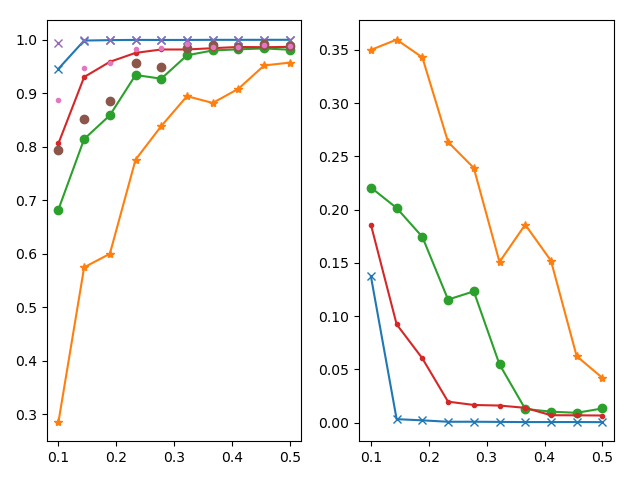

In [134]:
fig, ax = plt.subplots(1, 2)
fig.tight_layout()

ax[0].plot(train_fracs, result[0][0], 'x-')
ax[0].plot(train_fracs, result[0][3], '*-')
ax[0].plot(train_fracs, result[1][3], 'o-')
ax[0].plot(train_fracs, result[2][3], '.-')

ax[0].plot(train_fracs, result[0][6], 'x')
ax[0].plot(train_fracs, result[1][6], 'o')
ax[0].plot(train_fracs, result[2][6], '.')


ax[1].plot(train_fracs, result[0][1], 'x-')
ax[1].plot(train_fracs, result[0][4], '*-')
ax[1].plot(train_fracs, result[1][4], 'o-')
ax[1].plot(train_fracs, result[2][4], '.-')


now = datetime.now()
PATH = "./experiments/r_experiments/" + experiment_params["incentives"] + "/" + now.strftime("%d_%m_%Y__%H_%M_%S")
if not os.path.exists(PATH):
    os.makedirs(PATH)
    

np.savetxt(PATH + "/SVM_mean.csv", np.array(result[0][0]), delimiter=",")
np.savetxt(PATH + "/SVM_std.csv", np.array(result[0][1]), delimiter=",")
np.savetxt(PATH + "/SVM_accuracies.csv", np.array(result[0][2]), delimiter=",")

np.savetxt(PATH + "/SVM_mean_s.csv", np.array(result[0][3]), delimiter=",")
np.savetxt(PATH + "/SVM_std_s.csv", np.array(result[0][4]), delimiter=",")
np.savetxt(PATH + "/SVM_accuracies_s.csv", np.array(result[0][5]), delimiter=",")

np.savetxt(PATH + "/naive_SSVM_mean.csv", np.array(result[1][3]), delimiter=",")
np.savetxt(PATH + "/naive_SSVM_std.csv", np.array(result[1][4]), delimiter=",")
np.savetxt(PATH + "/naive_SSVM_accuracies.csv", np.array(result[1][5]), delimiter=",")

np.savetxt(PATH + "/SSVM_mean.csv", np.array(result[2][3]), delimiter=",")
np.savetxt(PATH + "/SSVM_std.csv", np.array(result[2][4]), delimiter=",")
np.savetxt(PATH + "/SSVM_accuracies.csv", np.array(result[2][5]), delimiter=",")

np.savetxt(PATH + "/lambdas.csv", lambdas, delimiter=",")
np.savetxt(PATH + "/train_fracs.csv", train_fracs, delimiter=",")

with open(PATH + '/experiment_params.json', 'w') as fp:
    json.dump(experiment_params, fp)
plt.savefig(PATH + "/graphs")

<IPython.core.display.Javascript object>


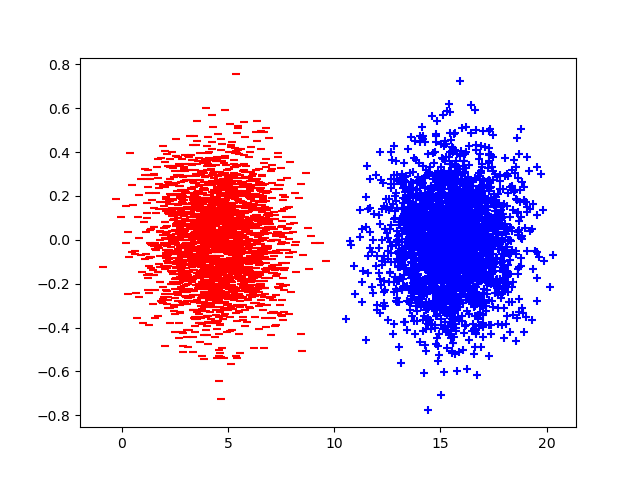

In [124]:
N = 5000
x_dim = 2
blobs_dist = 11
blobs_std = 1.5
pos_noise_frac = 0.0
neg_noise_frac = 0.0

X, y = gen_custom_normal_data(N, x_dim,
                              np.array([blobs_dist/2+10, 0]),
                              np.array([blobs_std, 0.2]),
                              np.array([-blobs_dist/2+10, 0]),
                              np.array([blobs_std, 0.2]),
                              pos_noise_frac=pos_noise_frac,
                              neg_noise_frac=neg_noise_frac)

visualize_data2D(X, y)

In [18]:
r = torch.ones(N)
model = SSVM(x_dim, "naive_SSVM")
learning_params = {"opt": torch.optim.Adam, "opt_kwargs": {"lr": 0.05},
                        "batch_size": 16, "epochs": 100, "verbose": False}

model.fit(X, r, y, None, None, None, **learning_params, lam=0)

([[0.4375, 0.25, 0.375, 0.1875, 0.25, 0.4375, 0.5],
  [0.3125, 0.375, 0.1875, 0.1875, 0.1875, 0.25, 0.0],
  [0.3125, 0.1875, 0.1875, 0.1875, 0.125, 0.25, 0.25],
  [0.1875, 0.1875, 0.1875, 0.375, 0.125, 0.125, 0.5],
  [0.3125, 0.25, 0.125, 0.25, 0.25, 0.0625, 0.25],
  [0.125, 0.1875, 0.25, 0.25, 0.1875, 0.125, 0.0],
  [0.1875, 0.1875, 0.25, 0.1875, 0.4375, 0.0, 0.25],
  [0.1875, 0.125, 0.125, 0.3125, 0.4375, 0.25, 0.0],
  [0.1875, 0.3125, 0.1875, 0.3125, 0.3125, 0.25, 0.25],
  [0.0625, 0.3125, 0.3125, 0.1875, 0.3125, 0.125, 0.0],
  [0.0625, 0.125, 0.3125, 0.375, 0.25, 0.125, 0.25],
  [0.125, 0.375, 0.1875, 0.1875, 0.25, 0.0625, 0.25],
  [0.125, 0.125, 0.25, 0.25, 0.125, 0.1875, 0.5],
  [0.3125, 0.0625, 0.1875, 0.25, 0.1875, 0.25, 0.0],
  [0.25, 0.25, 0.1875, 0.1875, 0.1875, 0.1875, 0.25],
  [0.0625, 0.1875, 0.1875, 0.1875, 0.25, 0.3125, 0.25],
  [0.3125, 0.125, 0.125, 0.1875, 0.1875, 0.1875, 0.0],
  [0.125, 0.1875, 0.1875, 0.25, 0.3125, 0.1875, 0.0],
  [0.375, 0.125, 0.1875, 0.1875, 0.1

<IPython.core.display.Javascript object>


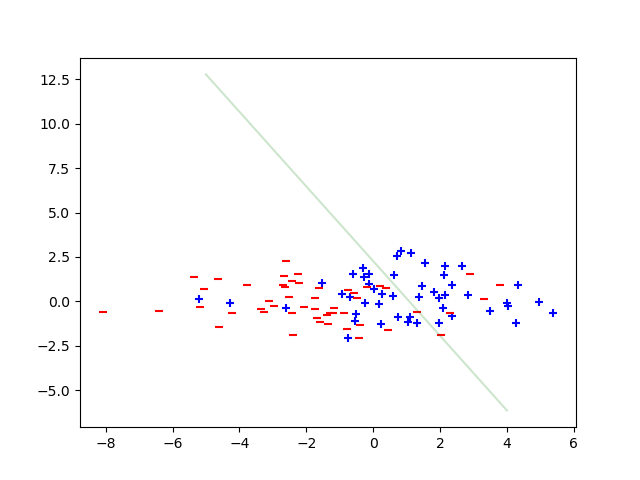

<IPython.core.display.Javascript object>


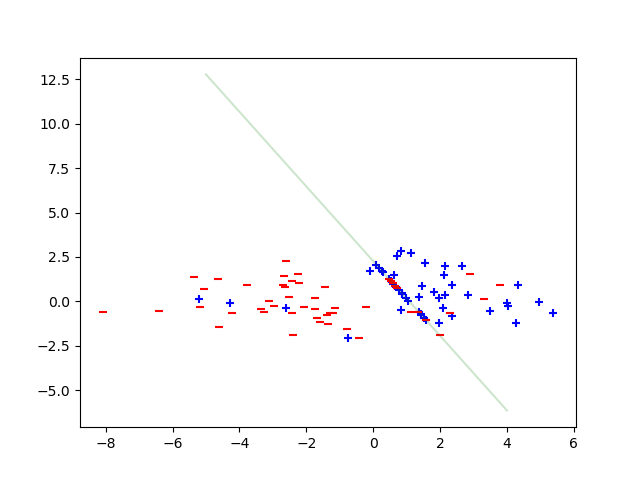

<IPython.core.display.Javascript object>


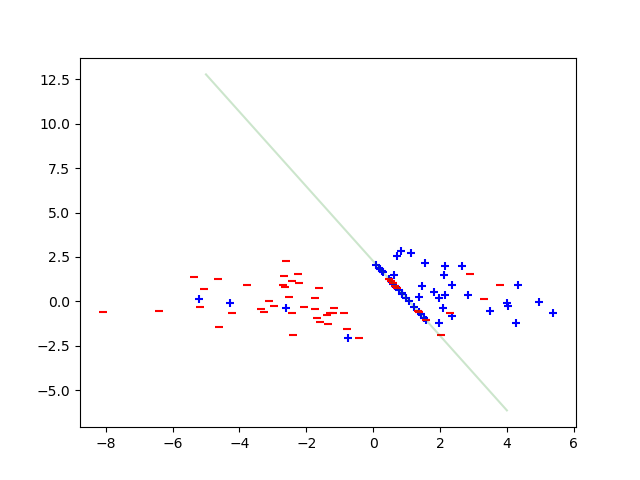

In [19]:
a = model.optimize_X(X, r).detach()
b = model.optimize_X_scmp(X, r).detach()
visualize_seperator2D(model, X, y)
visualize_seperator2D(model, b, y)
visualize_seperator2D(model, a, y)


In [34]:
r = torch.ones(N)*y
SVM_model = SSVM(x_dim, "SVM")
SSVM_model = SSVM(x_dim, "SSVM") 
learning_params = {"opt": torch.optim.Adam, "opt_kwargs": {"lr": 0.05},
                        "batch_size": 16, "epochs": 100, "verbose": False}

SVM_model.fit(X, r, y, None, None, None, **learning_params, lam=0)
SSVM_model.fit(X, r, y, None, None, None, **learning_params, lam=0)

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

([[0.1875,
   0.1875,
   0.0625,
   0.0625,
   0.0,
   0.0625,
   0.25,
   0.0625,
   0.0625,
   0.0,
   0.0625,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0625,
   0.0,
   0.0],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.125,
   0.0625,
   0.0,
   0.0625,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0625,
   0.0,
   0.0625,
   0.0,
   0.0],
  [0.0,
   0.0,
   0.0,
   0.0625,
   0.0625,
   0.0,
   0.0,
   0.0,
   0.0625,
   0.0,
   0.0,
   0.0625,
   0.0,
   0.125,
   0.0625,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.1875,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0625,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0625,
   0.0625,
   0.0],
  [0.0,
   0.0625,
   0.0,
   0.0625,
   0.0,
   0.0625,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0625,
   0.0,
   0.0,
   0.0,
   0.0625,
   0.0625,
   0.0,
   0.0625,
   0.0],
  [0.0,
   0.0,
   0.0625,
   0.0625,
   0.0,
   0.0,
   0.0625,
   0.0,
   0.0,
   0.0625,
   0.0,
   0.0625,
   0.0,
   0.0,
   0.0,
   0.0,


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


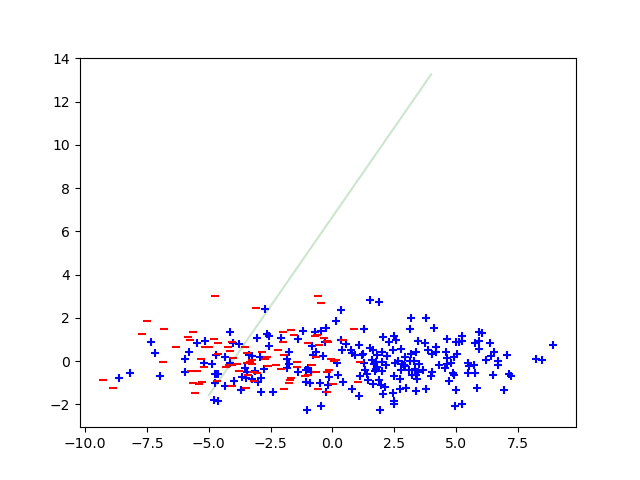

<IPython.core.display.Javascript object>


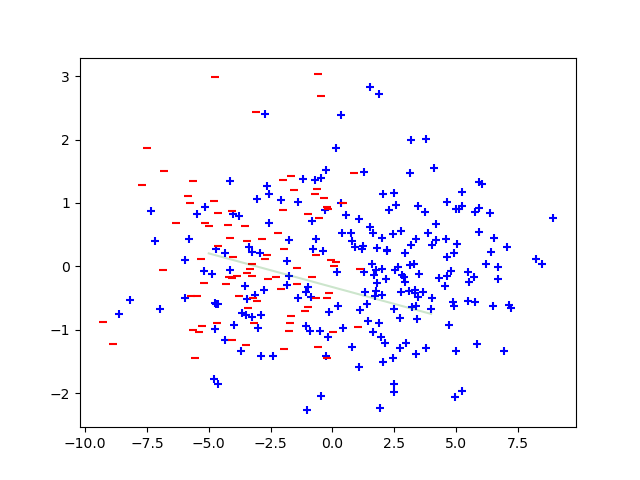

In [35]:
visualize_seperator2D(SVM_model, X, y)
visualize_seperator2D(SSVM_model, X, y)

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


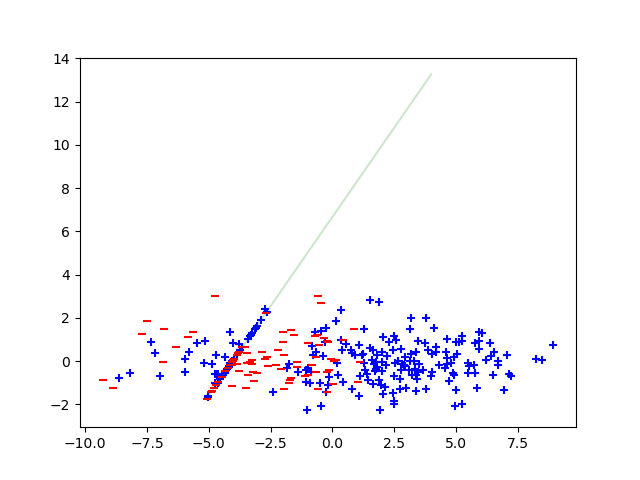

<IPython.core.display.Javascript object>


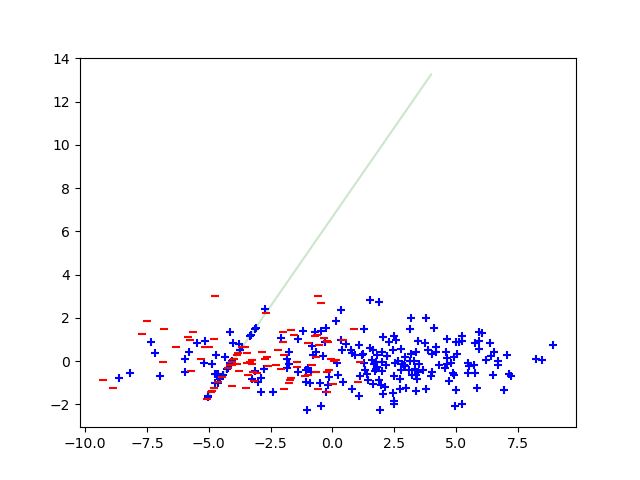

<IPython.core.display.Javascript object>


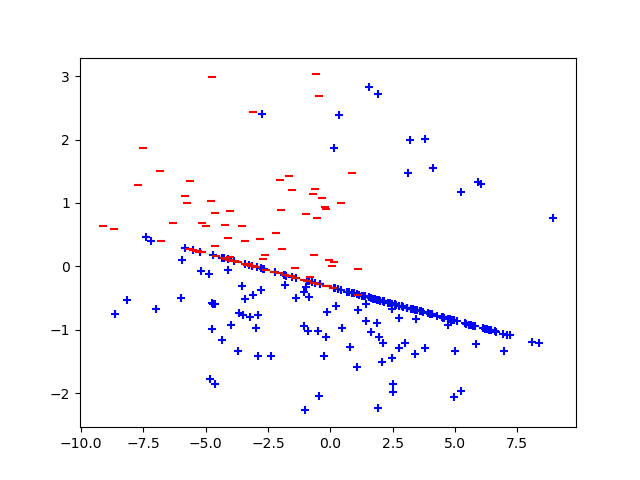

<IPython.core.display.Javascript object>


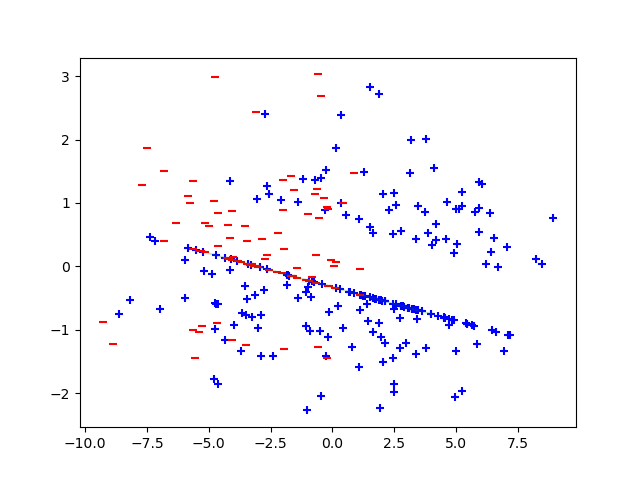

In [36]:
visualize_seperator2D(SVM_model, SVM_model.optimize_X(X, -y).detach(), y)
visualize_seperator2D(SVM_model, SVM_model.optimize_X(X, -y/2).detach(), y)

visualize_seperator2D(SSVM_model, SSVM_model.optimize_X(X, -y).detach(), y)
visualize_seperator2D(SSVM_model, SSVM_model.optimize_X(X, -y/2).detach(), y)

In [37]:
visualize_seperator2D(SSVM_model, SSVM_model.optimize_X(X, -y).detach(), y)
visualize_seperator2D(SSVM_model, SSVM_model.optimize_X_scmp(X, -y).detach(), y)

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

ValueError: Invalid dimensions () for Parameter value.